In [688]:
import pandas as pd
import numpy as np
import datetime
import random
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.linear_model import LinearRegression
#from sklearn import linear_model
from patsy import cr
from patsy import bs
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.model_selection import train_test_split

# utf-8 error, need to check encoding
with open('data\\SeoulBikeData.csv') as f:
    print(f)
    
df = pd.read_csv('C:\\Users\\Ping\\Desktop\\Project\\Bike_share\\data\\SeoulBikeData.csv', encoding = 'cp1252', dayfirst=True)

<_io.TextIOWrapper name='data\\SeoulBikeData.csv' mode='r' encoding='cp1252'>


In [629]:
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [689]:
df.describe(include='all')
# Count is uniform throughout, assume no NaN's

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
count,8760,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760,8760,8760
unique,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,2
top,05/08/2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,No Holiday,Yes
freq,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2208,8328,8465
mean,NaN,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068,NaN,NaN,NaN
std,NaN,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746,NaN,NaN,NaN
min,NaN,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000,NaN,NaN,NaN
50%,NaN,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000,NaN,NaN,NaN
75%,NaN,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000,NaN,NaN,NaN


In [690]:
print(df['Hour'][df['Functioning Day']=='No'].count())
print(df['Date'][df['Functioning Day']=='No'].nunique())
print(df['Date'][df['Functioning Day']=='No'].unique())
df['Rented Bike Count'][df['Functioning Day']=='No'].sum()

# 295 hours over 13 days when it wasn't functioning and there were no bikes rented
# Can try Multiple Imputation by Chained Equations - but really, only one column (Rented Bike Count) is invalid, so no need for fancy imputation
# But, assumption of Missing at Random is reasonable

295
13
['11/04/2018' '10/05/2018' '18/09/2018' '19/09/2018' '28/09/2018'
 '30/09/2018' '02/10/2018' '04/10/2018' '06/10/2018' '09/10/2018'
 '03/11/2018' '06/11/2018' '09/11/2018']


0

<AxesSubplot:xlabel='Hour'>

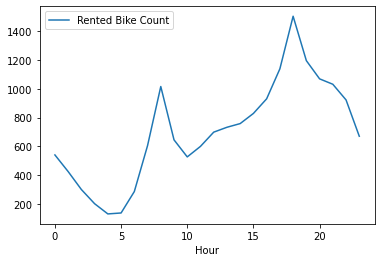

In [691]:
# Exploratory
# Daily pattern - expect few rentals at night?
df_daily = df[['Rented Bike Count','Hour']].groupby(['Hour']).mean()
df_daily.plot()
# Shows nightly lull and two rush hour peaks

Friday
Saturday


C:\Users\Ping\anaconda3\lib\site-packages\matplotlib\axes\_base.py:504: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


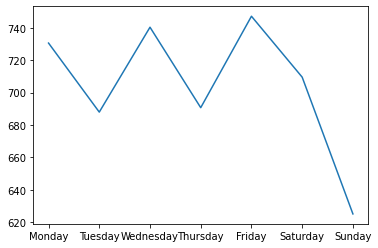

In [692]:
# Day of the week - be careful it's European dates DD-MM-YYYY

df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

df['Day of Week'] = df['Date'].dt.day_name()

print(df['Day of Week'].loc[0])
print(df['Day of Week'].loc[24])

df_weekly = df[['Day of Week','Rented Bike Count']].groupby(['Day of Week']).mean()

cat = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
df_weekly.index = pd.Categorical(df_weekly.index, categories=cat, ordered=True)
df_weekly = df_weekly.sort_index()

fig, axes = plt.subplots()
axes.plot(df_weekly['Rented Bike Count'])

(0.0, 1800.0)

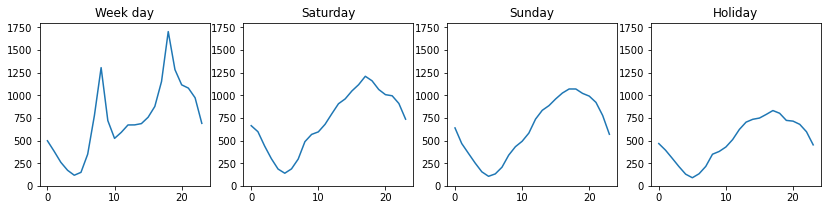

In [693]:
df_Sun = (
    df[['Hour','Rented Bike Count']]
    [df['Day of Week'] =='Sunday']
    .groupby('Hour')
    .agg(['mean',
          'sem'])
)

df_Sat = (
    df[['Hour','Rented Bike Count']]
    [df['Day of Week'] =='Saturday']
    .groupby('Hour')
    .agg(['mean',
         'sem'])
)

df_weekday = (
    df[['Hour','Rented Bike Count']]
    [(df['Day of Week']!='Saturday') & 
     (df['Day of Week']!='Sunday') &
     (df['Holiday']=='No Holiday')]
    .groupby('Hour')
    .agg(['mean',
          'sem'])
)

df_holiday = (
    df[['Hour','Rented Bike Count']]
    [(df['Holiday']=='Holiday')]
    .groupby('Hour')
    .agg(['mean',
          'sem'])
)

fig, axes = plt.subplots(1,4,figsize=(14,3))
axes[0].plot(df_weekday['Rented Bike Count']['mean'])
axes[0].set_title('Week day')
axes[0].set_ylim([0, 1800])
axes[1].plot(df_Sat['Rented Bike Count']['mean'])
axes[1].set_title('Saturday')
axes[1].set_ylim([0, 1800])
axes[2].plot(df_Sun['Rented Bike Count']['mean'])
axes[2].set_title('Sunday')
axes[2].set_ylim([0, 1800])
axes[3].plot(df_holiday['Rented Bike Count']['mean'])
axes[3].set_title('Holiday')
axes[3].set_ylim([0, 1800])

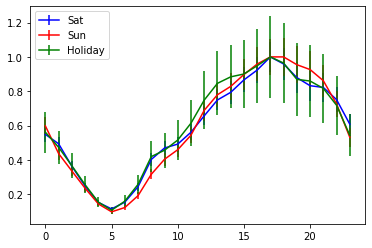

In [636]:
fig, axes = plt.subplots()

norm_Sat = np.max(df_Sat['Rented Bike Count']['mean'].values)
axes.errorbar(df_Sat['Rented Bike Count']['mean'].index,
            df_Sat['Rented Bike Count']['mean'].values/norm_Sat, 
            df_Sat['Rented Bike Count']['sem'].values/norm_Sat,  
            c = 'b')

norm_Sun = np.max(df_Sun['Rented Bike Count']['mean'].values)
axes.errorbar(df_Sun.index, 
            df_Sun['Rented Bike Count']['mean'].values/norm_Sun, 
            df_Sun['Rented Bike Count']['sem'].values/norm_Sun,  
            c ='r')

norm_holiday = np.max(df_holiday['Rented Bike Count']['mean'].values)
axes.errorbar(df_holiday.index, 
            df_holiday['Rented Bike Count']['mean'].values/norm_holiday, 
            df_holiday['Rented Bike Count']['sem'].values/norm_holiday,  
            c ='g')

axes.legend(['Sat','Sun','Holiday'])

plt.show()

# Since std(aX) = abs(a)*std(X), standard error should scale linearly with normalization

# Essentially the same - holiday is a small n set and may vary a lot by season, etc.

# Combine all non-work days for hourly

Text(0.5, 0, 'Hour')

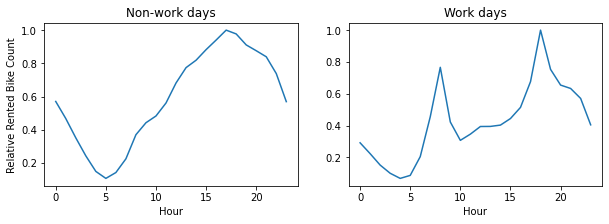

In [696]:
df['Workday'] = ((df['Day of Week']!='Saturday') & 
     (df['Day of Week']!='Sunday') &
     (df['Holiday']=='No Holiday'))

df_nonwork = (
    df[['Hour','Rented Bike Count']]
    [df['Workday']==False]
    .groupby('Hour')
    .mean()
)

df_nonwork['Rented Bike Re Max'] = df_nonwork.values / max(df_nonwork.values)

fig, ax = plt.subplots(1,2,figsize=(10,3))
ax[0].plot(df_nonwork['Rented Bike Re Max'])
ax[0].set_title('Non-work days')
ax[0].set_xlabel('Hour')
ax[0].set_ylabel('Relative Rented Bike Count')

df_weekday = (
    df[['Hour','Rented Bike Count']]
    [df['Workday']==True]
    .groupby('Hour')
    .mean()
)

df_weekday['Rented Bike Re Max'] = df_weekday.values / max(df_weekday.values)
ax[1].plot(df_weekday['Rented Bike Re Max'])
ax[1].set_title('Work days')
ax[1].set_xlabel('Hour')

# Looks like a recreation and a commuting component

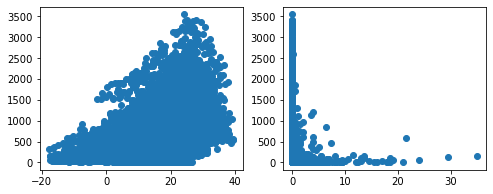

In [697]:
# Look at some expected correlations after deseasonalizing - e.g., rain, temperature

fig, axes = plt.subplots(1,2,figsize=(8,3))
axes[0].scatter(df['Temperature(°C)'], df['Rented Bike Count'])

axes[1].scatter(df['Rainfall(mm)'], df['Rented Bike Count'])

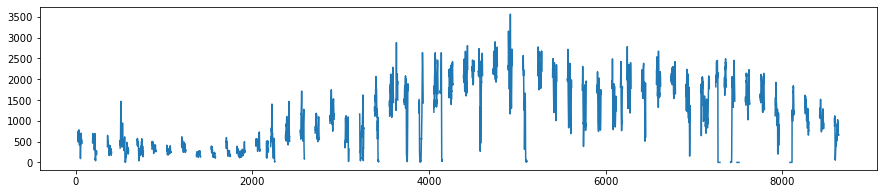

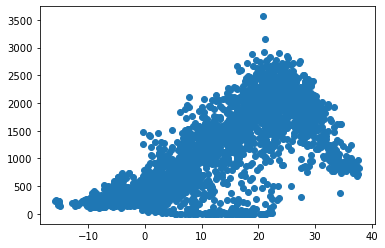

In [698]:
# Want to look at these after removing daily trend 

# Non-work days
for i in range(0,len(df)):
    if ((df['Day of Week'][i] in ['Saturday','Sunday']) or
        (df['Holiday'][i] == 'Holiday')):
        df.loc[i,'de_daily_nw'] = (
            df.loc[i,'Rented Bike Count']
            /df_nonwork.loc[df['Hour'][i],'Rented Bike Re Max'])  
        df.loc[i,'de_daily'] = (
            df.loc[i,'Rented Bike Count']
            /df_nonwork.loc[df['Hour'][i],'Rented Bike Re Max'])   
        # Multiplicative removal of nonwork daily average

# Built in produces weird results for intervening missing points on the other days
# decomp = seasonal_decompose(temp['Rented Bike Count'], model='additive', period=24)
# seas_Sun = decomp.seasonal    

fig, axes = plt.subplots(1,1, figsize=(15,3))
axes.plot(df['de_daily_nw'])

fig2 = plt.figure()
plt.scatter(df['Temperature(°C)'][df['Rainfall(mm)']<3], df['de_daily_nw'][df['Rainfall(mm)']<3])

# There is a non-surprising non-linear relationship with temperature
# People don't want to ride when it is too hot or too cold

In [699]:
for i in range(0,len(df)):
    if ((df['Day of Week'][i] not in ['Saturday','Sunday']) and
        (df['Holiday'][i] != 'Holiday')):
        df.loc[i,'de_daily_w'] = (
            df.loc[i,'Rented Bike Count']
            /df_weekday.loc[df['Hour'][i],'Rented Bike Re Max'])  
        df.loc[i,'de_daily'] = (
            df.loc[i,'Rented Bike Count']
            /df_weekday.loc[df['Hour'][i],'Rented Bike Re Max'])   
        
# In the end decided to use pooled de_daily between work and nonwork days to facilitate continuous time series time analysis

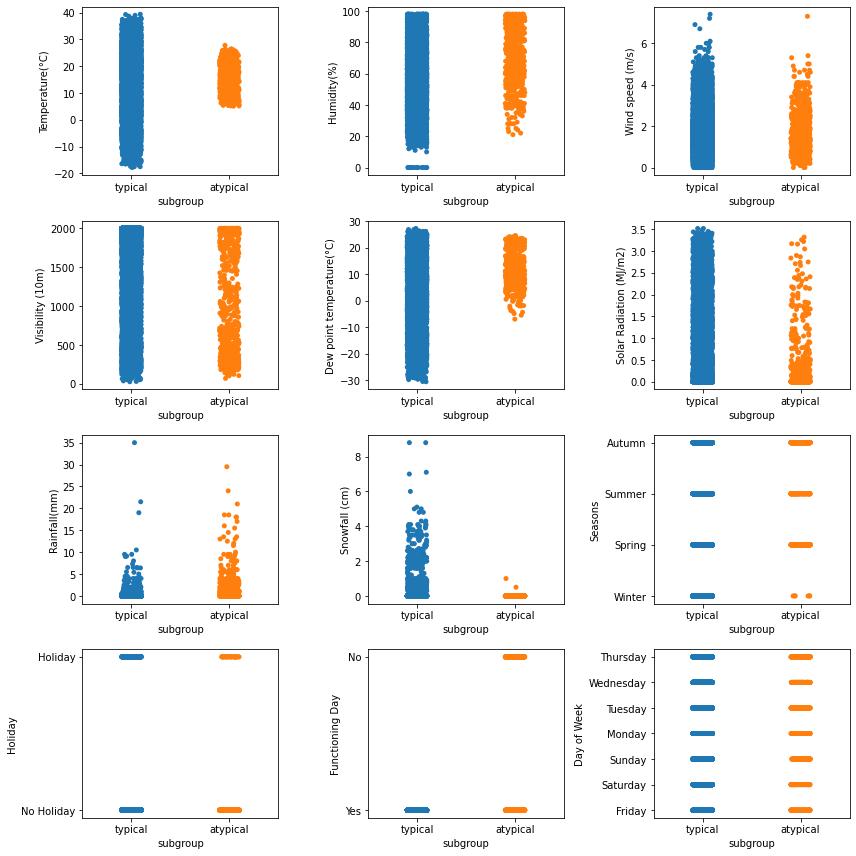

In [700]:
df.loc[(df['Temperature(°C)']>5) & (df['de_daily']<300), 'subgroup'] = 'atypical'
df.loc[(df['Temperature(°C)']<5) | (df['de_daily']>300), 'subgroup'] = 'typical'

fig = plt.figure(figsize=(12,12))

for i in range(3,df.shape[1]-5):
    ax = fig.add_subplot(4, 3, i-2)
    plt.sca(ax)
    sns.stripplot(data = df,
              x = 'subgroup',
              y = df.columns[i],
              )
fig.tight_layout()

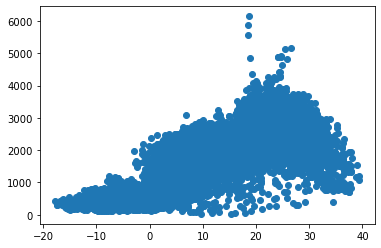

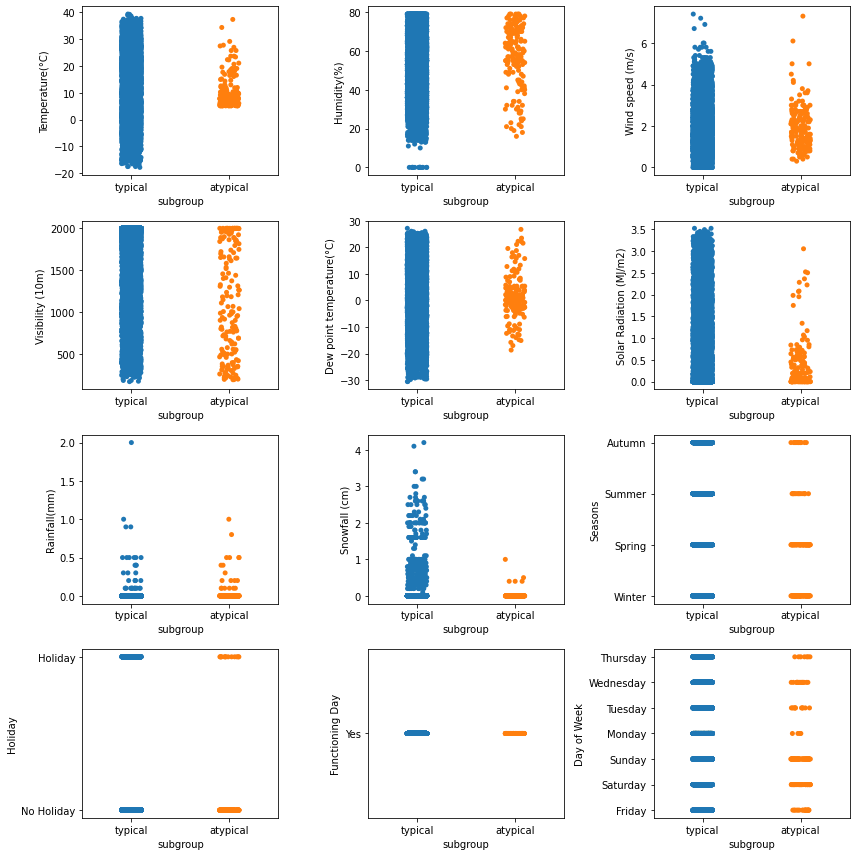

In [701]:
fig4 = plt.figure()
inds = (
    (df['Rainfall(mm)']<3) & 
    (df['Functioning Day']=='Yes') & 
    (df['Humidity(%)']<80)  
)
plt.scatter(df['Temperature(°C)'][inds], df['de_daily'][inds])

df.loc[(df['Temperature(°C)']>5) & (df['de_daily']<700), 'subgroup'] = 'atypical'
df.loc[(df['Temperature(°C)']<5) | (df['de_daily']>700), 'subgroup'] = 'typical'
df.loc[~inds,'subgroup'] = None

# After accounting for humidity < 80%, rain less than 3 mm, and ensuring it is a functioning day for the bike share system
# Atypical group is a group of points with reasonably warm temperatures but low bike demand
# Let's see what the characteristics of those days were
# From the graphs, we see they are still higher humidity / dew point and overcast

fig = plt.figure(figsize=(12,12))

for i in range(3,df.shape[1]-5):
    ax = fig.add_subplot(4, 3, i-2)
    plt.sca(ax)
    sns.stripplot(data = df,
              x = 'subgroup',
              y = df.columns[i],
              )
fig.tight_layout()

In [702]:
df[df['subgroup']=='atypical']
# Warm winter day with snowfall
# Very overcast day based on solar radiation
# April 15th 2018 Seoul was enshrouded in fine dust and sand from China? https://www.upi.com/Top_News/World-News/2018/04/15/Fine-dust-levels-soar-in-South-Korea/5581523776231/
# But not reflected in visibility?
# Certainly pollution levels (and in a place like California, fires etc.) should be included in such models

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Day of Week,Workday,de_daily_nw,de_daily,de_daily_w,subgroup
39,2017-12-02,589,15,7.6,41,2.3,1953,-4.8,0.74,0.0,0.0,Winter,No Holiday,Yes,Saturday,False,667.332910,667.332910,NaN,atypical
40,2017-12-02,618,16,6.4,48,2.6,1945,-3.8,0.22,0.0,0.0,Winter,No Holiday,Yes,Saturday,False,657.232449,657.232449,NaN,atypical
41,2017-12-02,572,17,6.0,51,2.5,1891,-3.3,0.06,0.0,0.0,Winter,No Holiday,Yes,Saturday,False,572.000000,572.000000,NaN,atypical
42,2017-12-02,489,18,5.5,53,1.5,1697,-3.3,0.00,0.0,0.0,Winter,No Holiday,Yes,Saturday,False,500.452026,500.452026,NaN,atypical
62,2017-12-03,563,14,7.6,76,1.2,422,3.6,0.69,0.0,0.0,Winter,No Holiday,Yes,Sunday,False,687.507852,687.507852,NaN,atypical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8297,2018-11-11,660,17,8.9,57,3.0,1149,0.8,0.03,0.0,0.0,Autumn,No Holiday,Yes,Sunday,False,660.000000,660.000000,NaN,atypical
8520,2018-11-21,119,0,7.2,74,1.2,772,2.8,0.00,0.2,0.0,Autumn,No Holiday,Yes,Wednesday,True,NaN,407.424172,407.424172,atypical
8634,2018-11-25,663,18,7.3,72,0.7,530,2.5,0.00,0.0,0.4,Autumn,No Holiday,Yes,Sunday,False,678.526981,678.526981,NaN,atypical
8635,2018-11-25,616,19,6.3,73,1.1,524,1.8,0.00,0.0,0.4,Autumn,No Holiday,Yes,Sunday,False,676.148096,676.148096,NaN,atypical


Text(0, 0.5, 'Rented Bike Count')

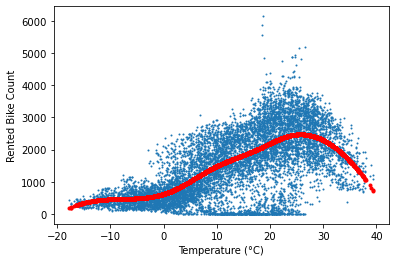

In [705]:
# Assess univariate spline regression using Patsy library, knot locations

fig4 = plt.figure()

df2 = df

x = df2['Temperature(°C)'][df['Functioning Day']=='Yes']
y = df2['de_daily'][df['Functioning Day']=='Yes']

x_basis = bs(x, df=7)
model = LinearRegression().fit(x_basis, y)
y_hat = model.predict(x_basis)

plt.scatter(df2['Temperature(°C)'], df2['de_daily'], s=1)
plt.plot(x, y_hat, ls="", marker=".", color="red")
plt.xlabel('Temperature (°C)')
plt.ylabel('Rented Bike Count')

# It's two groups?

C:\Users\Ping\AppData\Local\Temp/ipykernel_14812/786173628.py:7: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  mod = sm.GLM(df2['de_daily'], transformed_x1, family=sm.families.Poisson(link=sm.families.links.log))


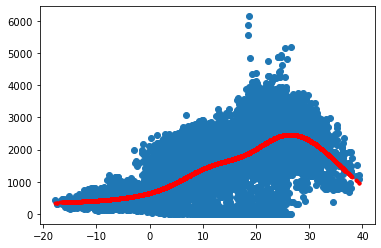

In [706]:
x = df2['Temperature(°C)']
y = df2['de_daily']

transformed_x1 = dmatrix("bs(df2['Temperature(°C)'], df=7)",
                        {'df2.temp':df2['Temperature(°C)']}, return_type='dataframe')

mod = sm.GLM(df2['de_daily'], transformed_x1, family=sm.families.Poisson(link=sm.families.links.log))
res = mod.fit()
y_hat = res.predict()

plt.scatter(x, y)
plt.plot(x, y_hat, ls="", marker=".", color="red")
plt.show()

df2['resid'] = y-y_hat

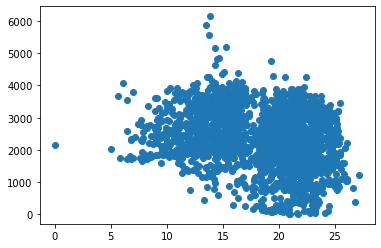

In [707]:
# Effect of dew point, which may be more tightly related to subjective comfort outdoors

fig4 = plt.figure()
inds = (
    (df['Rainfall(mm)']<3) & 
    (df['Functioning Day']=='Yes') &
    (df['Seasons']=='Summer')   
)
# Negative relationship in summer, but overall actually positive relationship, due to correlation with temperature and season?

plt.scatter(df['Dew point temperature(°C)'][inds], df['de_daily'][inds])

# Still, South Korea's climate seems pretty far from the oppressive regime
# Hence, a relatively minor factor


Text(0, 0.5, 'Bike Count Residual After Temperature Spline')

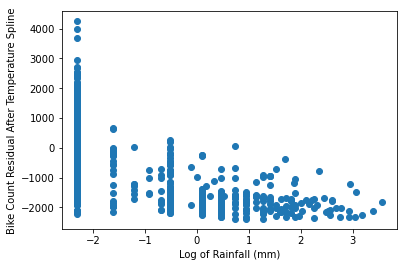

In [712]:
# Rain

fig5 = plt.figure()
inds = ( 
    (df2['Functioning Day']=='Yes') & 
    (df2['Temperature(°C)']<30) &
    (df2['Temperature(°C)']>15)
)

#plt.scatter(df2['Rainfall(mm)'][inds], df2['resid'][inds])
plt.scatter(np.log(df2['Rainfall(mm)'][inds]+0.1), df2['resid'][inds])
#plt.scatter(np.log(df2['Rainfall(mm)'][inds]+0.1), df2['de_daily'][inds])
plt.xlabel('Log of Rainfall (mm)')
plt.ylabel('Bike Count Residual After Temperature Spline')

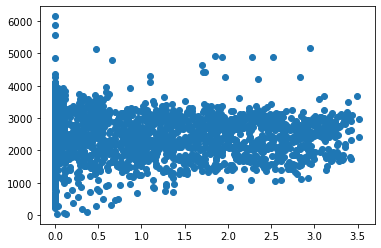

In [654]:
# Sun

inds = (
    (df['Rainfall(mm)']<3) & 
    (df['Functioning Day']=='Yes') & 
    (df['Humidity(%)']<80)  &
    (df['Temperature(°C)']<30) &
    (df['Temperature(°C)']>15)
)
plt.scatter(df['Solar Radiation (MJ/m2)'][inds], df['de_daily'][inds])
# A group of low solar radiation days also had low usage, but this was not necessarily the case - why so many days state this as 0?


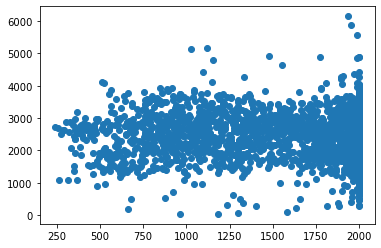

In [656]:
# Visibility

inds = (
    (df['Rainfall(mm)']<3) & 
    (df['Functioning Day']=='Yes') & 
    (df['Humidity(%)']<80)  &
    (df['Temperature(°C)']<30) &
    (df['Temperature(°C)']>15)
)
plt.scatter(df['Visibility (10m)'][inds], df['de_daily'][inds])

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 8760
Model:                            GLM   Df Residuals:                     8751
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.6320e+06
Date:                Thu, 06 Jan 2022   Deviance:                   3.1890e+06
Time:                        13:31:31   Pearson chi2:                 2.68e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4110      0.010    457.336      0.000       4.392       4.430
x1             0.0882      0.014      6.269      0.000       0.061       0.116
x2             0.2885      0.009     33.393      0.000       0.272       0.305
x3             1.5198      0.010    153.974      0.000       1.500       1.539
x4             1.6529      0.009    177.405      0.000       1.635       1.671
x5             2.2735      0.010    233.097      0.000       2.254       2.293
x6             1.5941      0.010    162.442      0.000       1.575       1.613
x7             1.1195      0.011     99.469      0.000       1.097       1.142
x8            -0.6335      0.001   -662.483      0.000      -0.635      -0.632
==============================================================================
"""

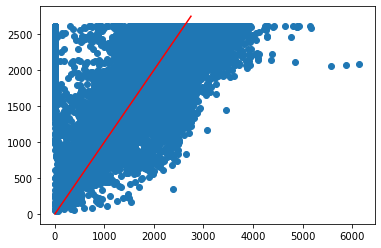

In [713]:
df3 = pd.DataFrame()
df3['x1'] = df2['Temperature(°C)'] 
df3['x2'] = df2['Rainfall(mm)']
df3['y'] = df2['de_daily']

transformed_x = dmatrix("bs(x1, df=7) + np.log(x2+0.1)",
                        df3)

mod = sm.GLM(df3.y, transformed_x, family=sm.families.Poisson(link=sm.families.links.log()))
res = mod.fit()
y_hat = res.predict()

#mod = smf.glm(formula='y ~ C(x1) + C(x2) + C(x3) + x4 + x5', data=data,family=sm.families.Poisson(link=sm.families.links.log()))
#reg = mod.fit()

plt.scatter(df3.y, y_hat)
ymax = plt.ylim()[1]
plt.plot(np.array([0,ymax]),np.array([0,ymax]), '-r')

df2['resid'] = df3.y-y_hat

res.summary()

Dew point: corr = -0.016192425586849413, p-val = 0.12966833693095134
Dew point in summer: corr = -0.16191842788347693, p-val = 1.9376721431084523e-14
Wind speed: corr = -0.10346458670873918, p-val = 2.7756148475512046e-22
Wind speed in winter: corr = -0.09030060187026187, p-val = 2.6345634874777136e-05
Sun: corr = -0.045183559178573106, p-val = 2.3316576153061436e-05
Sun not summer: corr = 0.008433615600343038, p-val = 0.4949000515257811


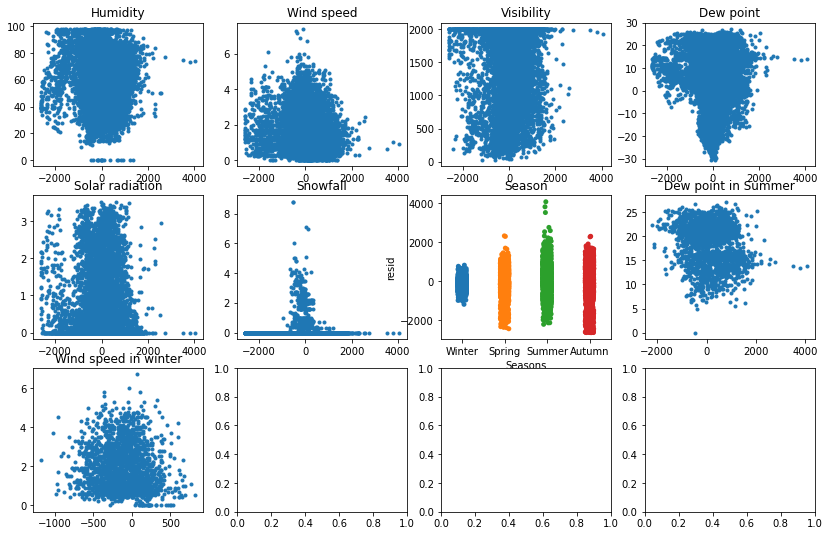

In [714]:
from scipy import stats

fig, axes = plt.subplots(3,4,figsize=(14,9))
axes[0,0].plot(df2['resid'],df2['Humidity(%)'], '.')
axes[0,0].set_title('Humidity')

axes[0,1].plot(df2['resid'],df2['Wind speed (m/s)'], '.')
axes[0,1].set_title('Wind speed')

axes[0,2].plot(df2['resid'],df2['Visibility (10m)'], '.')
axes[0,2].set_title('Visibility')

axes[0,3].plot(df2['resid'],df2['Dew point temperature(°C)'], '.')
axes[0,3].set_title('Dew point')

axes[1,0].plot(df2['resid'],df2['Solar Radiation (MJ/m2)'], '.')
axes[1,0].set_title('Solar radiation')

axes[1,1].plot(df2['resid'],df2['Snowfall (cm)'], '.')
axes[1,1].set_title('Snowfall')

axes[1,2].set_title('Season')
sns.stripplot(data = df2,
              x = 'Seasons',
              y = 'resid',
              ax = axes[1,2]
              )

axes[1,3].plot(df2['resid'][df2['Seasons']=='Summer'],df2['Dew point temperature(°C)'][df2['Seasons']=='Summer'], '.')
axes[1,3].set_title('Dew point in Summer')

corr,p = stats.pearsonr(df2['resid'],df2['Dew point temperature(°C)'])
print(f'Dew point: corr = {corr}, p-val = {p}')

corr,p = stats.pearsonr(df2['resid'][df2['Seasons']=='Summer'],df2['Dew point temperature(°C)'][df2['Seasons']=='Summer'])
print(f'Dew point in summer: corr = {corr}, p-val = {p}')

axes[2,0].plot(df2['resid'][df2['Seasons']=='Winter'],df2['Wind speed (m/s)'][df2['Seasons']=='Winter'], '.')
axes[2,0].set_title('Wind speed in winter')

corr,p = stats.pearsonr(df2['resid'],df2['Wind speed (m/s)'])
print(f'Wind speed: corr = {corr}, p-val = {p}')

corr,p = stats.pearsonr(df2['resid'][df2['Seasons']=='Winter'],df2['Wind speed (m/s)'][df2['Seasons']=='Winter'])
print(f'Wind speed in winter: corr = {corr}, p-val = {p}')    # Much stronger effect in winter

corr,p = stats.pearsonr(df2['resid'],df2['Solar Radiation (MJ/m2)'])
print(f'Sun: corr = {corr}, p-val = {p}')    

corr,p = stats.pearsonr(df2['resid'][df2['Seasons']!='Summer'],df2['Solar Radiation (MJ/m2)'][df2['Seasons']!='Summer'])
print(f'Sun not summer: corr = {corr}, p-val = {p}')    

# Residuals after taking into account temperature and rain don't seem biased for seasons. If we wanted to use the categorical season variable, we could use: 
# Adding them in now could cause multicollinearity type issues

0.820019977298692


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 8760
Model:                            GLM   Df Residuals:                     8743
Model Family:                 Poisson   Df Model:                           16
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -6.7022e+05
Date:                Thu, 06 Jan 2022   Deviance:                   1.2655e+06
Time:                        13:33:29   Pearson chi2:                 1.21e+06
No. Iterations:                    33                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.7550   1.82e+04     -0.002      0.999   -3.58e+04    3.57e+04
x1             0.7956      0.015     54.132      0.000       0.767       0.824
x2             0.7928      0.009     86.598      0.000       0.775       0.811
x3             1.5351      0.011    145.338      0.000       1.514       1.556
x4             1.9631      0.010    194.975      0.000       1.943       1.983
x5             2.3757      0.011    222.997      0.000       2.355       2.397
x6             1.9470      0.011    182.388      0.000       1.926       1.968
x7             1.2688      0.012    105.089      0.000       1.245       1.292
x8            -0.6286      0.001   -647.386      0.000      -0.630      -0.627
x9            -0.0137   6.65e-05   -205.858      0.000      -0.014      -0.014
x10            0.2577      0.002    121.872      0.000       0.254       0.262
x11           -0.0076      0.000    -60.108      0.000      -0.008      -0.007
x12           -0.0669      0.000   -204.262      0.000      -0.068      -0.066
x13           -0.6560      0.002   -279.550      0.000      -0.661      -0.651
x14           -0.0113      0.001    -12.312      0.000      -0.013      -0.010
x15           33.9173   1.82e+04      0.002      0.999   -3.57e+04    3.58e+04
x16            0.4593      0.001    703.299      0.000       0.458       0.461
==============================================================================
"""

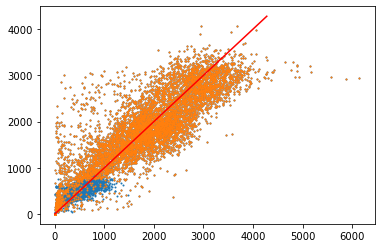

In [718]:
df4 = pd.get_dummies(df2,columns = ['Seasons'])
df4 = pd.get_dummies(df4,columns = ['Functioning Day'])
df4 = pd.get_dummies(df4,columns = ['Workday'])     
# Allow workday model to be different, even after de-seasoning the day pattern

df5 = pd.DataFrame()
df5['temp'] = df4['Temperature(°C)']    # Careful this column name can be confused with temporary
df5['rain'] = df4['Rainfall(mm)']
df5['dew'] = df4['Dew point temperature(°C)']
df5['humidity'] = df4['Humidity(%)']
df5['wind'] = df4['Wind speed (m/s)']
df5['sun'] = df4['Solar Radiation (MJ/m2)']
df5['winter'] = df4['Seasons_Winter']
df5['summer'] = df4['Seasons_Summer']
df5['spring'] = df4['Seasons_Spring']     # Drop one to avoid multicollinearity
df5['func'] = df4['Functioning Day_Yes']
df5['workday'] = df4['Workday_True']

df5['y'] = df4['de_daily']
                     
transformed_x = dmatrix("bs(temp, df=7) + np.log(rain+0.1) + dew*summer + wind*winter + func + workday",
                        df5)

mod = sm.GLM(df5.y, transformed_x, family=sm.families.Poisson(link=sm.families.links.log()))
res = mod.fit()
y_hat = res.predict()

plt.scatter(df5.y, y_hat, s=1)
plt.scatter(df5.y[df5.winter==0], y_hat[df5.winter==0], s=1)
ymax = plt.ylim()[1]
plt.plot(np.array([0,ymax]),np.array([0,ymax]), '-r')

pseudoR2 = 1 - (res.deviance/res.null_deviance)
print(pseudoR2)

res.summary()


In [719]:
transformed_x

DesignMatrix with shape (8760, 17)
  Columns:
    ['Intercept',
     'bs(temp, df=7)[0]',
     'bs(temp, df=7)[1]',
     'bs(temp, df=7)[2]',
     'bs(temp, df=7)[3]',
     'bs(temp, df=7)[4]',
     'bs(temp, df=7)[5]',
     'bs(temp, df=7)[6]',
     'np.log(rain + 0.1)',
     'dew',
     'summer',
     'dew:summer',
     'wind',
     'winter',
     'wind:winter',
     'func',
     'workday']
  Terms:
    'Intercept' (column 0)
    'bs(temp, df=7)' (columns 1:8)
    'np.log(rain + 0.1)' (column 8)
    'dew' (column 9)
    'summer' (column 10)
    'dew:summer' (column 11)
    'wind' (column 12)
    'winter' (column 13)
    'wind:winter' (column 14)
    'func' (column 15)
    'workday' (column 16)
  (to view full data, use np.asarray(this_obj))

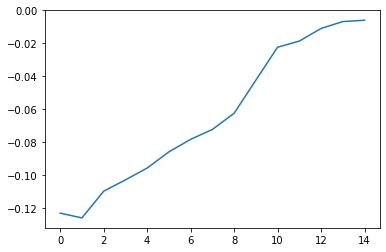

In [716]:
crosscorr = sm.tsa.stattools.ccf(df['Rainfall(mm)'], df['Rented Bike Count'])
plt.plot(crosscorr[0:15])

# Effect of rain can last up to 12 hours - wet roads / puddles, etc.?

In [720]:
# Adding in some distributed lag 

df5['rain'] = np.log(df4['Rainfall(mm)']+0.1)
df5['rainL1'] = pd.concat([pd.Series([np.NaN]),np.log(df4['Rainfall(mm)'][:-1]+0.1)]).values
df5['rainL2'] = pd.concat([pd.Series([np.NaN]*2),np.log(df4['Rainfall(mm)'][:-2]+0.1)]).values
df5['rainL3'] = pd.concat([pd.Series([np.NaN]*3),np.log(df4['Rainfall(mm)'][:-3]+0.1)]).values
df5['rainL4'] = pd.concat([pd.Series([np.NaN]*4),np.log(df4['Rainfall(mm)'][:-4]+0.1)]).values
df5['rainL5'] = pd.concat([pd.Series([np.NaN]*5),np.log(df4['Rainfall(mm)'][:-5]+0.1)]).values
df5['rainL6'] = pd.concat([pd.Series([np.NaN]*6),np.log(df4['Rainfall(mm)'][:-6]+0.1)]).values
df5['hour'] = df4['Hour']

df5['demand'] = df4['Rented Bike Count']

df5 = df5.dropna()

0.8490721978863606


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 8754
Model:                            GLM   Df Residuals:                     8734
Model Family:                 Poisson   Df Model:                           19
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.6798e+05
Date:                Thu, 06 Jan 2022   Deviance:                   1.0610e+06
Time:                        13:36:32   Pearson chi2:                 1.04e+06
No. Iterations:                    33                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.1501   1.82e+04     -0.002      0.999   -3.56e+04    3.56e+04
x1             0.7071      0.015     48.084      0.000       0.678       0.736
x2             0.7097      0.009     77.912      0.000       0.692       0.728
x3             1.3623      0.011    129.121      0.000       1.342       1.383
x4             1.7683      0.010    175.876      0.000       1.749       1.788
x5             2.1193      0.011    198.989      0.000       2.098       2.140
x6             1.5608      0.011    146.181      0.000       1.540       1.582
x7             0.9981      0.012     82.842      0.000       0.974       1.022
x8            -0.4187      0.001   -392.281      0.000      -0.421      -0.417
x9            -0.1841      0.001   -187.955      0.000      -0.186      -0.182
x10           -0.1465      0.001   -170.174      0.000      -0.148      -0.145
x11           -0.0482      0.001    -57.775      0.000      -0.050      -0.047
x12           -0.0701      0.001    -94.317      0.000      -0.072      -0.069
x13           -0.0072   6.92e-05   -104.465      0.000      -0.007      -0.007
x14            0.2232      0.002    104.466      0.000       0.219       0.227
x15           -0.0058      0.000    -45.319      0.000      -0.006      -0.006
x16           -0.0584      0.000   -187.950      0.000      -0.059      -0.058
x17           -0.6694      0.002   -389.686      0.000      -0.673      -0.666
x18           33.9257   1.82e+04      0.002      0.999   -3.55e+04    3.56e+04
x19            0.4641      0.001    711.171      0.000       0.463       0.465
==============================================================================
"""

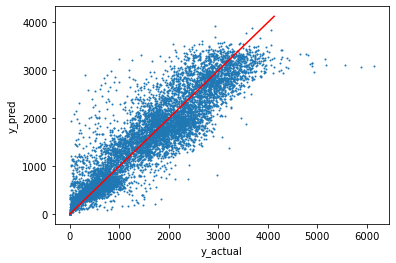

In [727]:
transformed_x = dmatrix("bs(temp, df=7) + rain + rainL1 + rainL2 + rainL3 + rainL4 + dew*summer + wind + winter + func + workday",
                        df5)

mod = sm.GLM(df5.y, transformed_x, family=sm.families.Poisson(link=sm.families.links.log()))
res = mod.fit()
df5['y_hat'] = res.predict()

plt.scatter(df5.y, df5.y_hat, s=1)
plt.xlabel('y_actual')
plt.ylabel('y_pred')
#plt.scatter(df5.y[df5.winter==0], df5.y_hat[df5.winter==0])
ymax = plt.ylim()[1]
plt.plot(np.array([0,ymax]),np.array([0,ymax]), '-r')

pseudoR2 = 1 - (res.deviance/res.null_deviance)
print(pseudoR2)   # Not best measure for GLM, but convenient

res.summary()

# Adding more rain history helps, but incrementally, at cost of lots of free parameters, so limit to two
# Not much of an effect on prediction, possibly because heavy rain days are a minority? Keeping a little bit of history, but not a ton of free variables


In [728]:
# See performance on split out test set

transformed_x = dmatrix("bs(temp, df=7) + rain + rainL1 + rainL2 + rainL3 + rainL4 + dew*summer + wind + winter + func + workday",
                        df5)

inds_train = random.sample(range(0,len(df5)),k=round(0.8*len(df5)))
inds_test = list(set(range(0,len(df5))) - set(inds_train))

mod = sm.GLM(df5.iloc[inds_train, df5.columns.get_loc('y')], 
             transformed_x[inds_train], 
             family=sm.families.Poisson(link=sm.families.links.log()))
res = mod.fit()
df5['y_hat'] = res.predict(transformed_x)

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 7003
Model:                            GLM   Df Residuals:                     6983
Model Family:                 Poisson   Df Model:                           19
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.4933e+05
Date:                Thu, 06 Jan 2022   Deviance:                   8.3882e+05
Time:                        13:37:32   Pearson chi2:                 8.25e+05
No. Iterations:                    32                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.1674    1.2e+04     -0.002      0.998   -2.36e+04    2.36e+04
x1             0.7106      0.016     43.446      0.000       0.679       0.743
x2             0.7179      0.010     71.069      0.000       0.698       0.738
x3             1.3610      0.012    116.010      0.000       1.338       1.384
x4             1.7780      0.011    159.096      0.000       1.756       1.800
x5             2.1165      0.012    178.779      0.000       2.093       2.140
x6             1.5822      0.012    133.155      0.000       1.559       1.605
x7             1.0027      0.013     74.802      0.000       0.976       1.029
x8            -0.4220      0.001   -352.619      0.000      -0.424      -0.420
x9            -0.1778      0.001   -162.493      0.000      -0.180      -0.176
x10           -0.1561      0.001   -157.516      0.000      -0.158      -0.154
x11           -0.0382      0.001    -39.520      0.000      -0.040      -0.036
x12           -0.0745      0.001    -89.546      0.000      -0.076      -0.073
x13           -0.0076   7.71e-05    -98.007      0.000      -0.008      -0.007
x14            0.2402      0.002    101.848      0.000       0.236       0.245
x15           -0.0067      0.000    -46.774      0.000      -0.007      -0.006
x16           -0.0606      0.000   -174.135      0.000      -0.061      -0.060
x17           -0.6721      0.002   -350.007      0.000      -0.676      -0.668
x18           32.9399    1.2e+04      0.003      0.998   -2.36e+04    2.36e+04
x19            0.4650      0.001    635.244      0.000       0.464       0.466
==============================================================================
"""

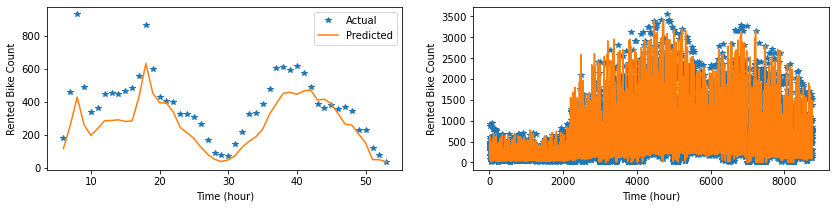

In [731]:
df5.loc[df5['workday']==0,'demand_pred'] = (
    df5['y_hat'][df5['workday']==0].values *
    df_nonwork['Rented Bike Re Max'][df5['hour'][df5['workday']==0]].values
)

df5.loc[df5['workday']==1,'demand_pred'] = (
    df5['y_hat'][df5['workday']==1].values *
    df_weekday['Rented Bike Re Max'][df5['hour'][df5['workday']==1]].values
)

fig, axes = plt.subplots(1,2,figsize=(14,3))
axes[0].plot(df5.index[0:48], df5['demand'][0:48], '*')
axes[0].plot(df5.index[0:48], df5['demand_pred'][0:48], '-')
axes[0].set_xlabel('Time (hour)')
axes[0].set_ylabel('Rented Bike Count')
axes[0].legend(['Actual', 'Predicted'])

axes[1].plot(df5.index, df5.demand, '*')
axes[1].plot(df5.index, df5.demand_pred, '-')
axes[1].set_xlabel('Time (hour)')
axes[1].set_ylabel('Rented Bike Count')

# Daily curve may shift seasonally due to sundown etc.

df6 = pd.merge(df, df5['demand_pred'], how='left', left_index=True, right_index=True)


In [732]:
from sklearn.metrics import r2_score

col_d = df5.columns.get_loc('demand')
col_d_hat = df5.columns.get_loc('demand_pred')

MAE = np.abs(np.subtract(df5.iloc[inds_train, col_d], df5.iloc[inds_train, col_d_hat])).mean()
print(f'Mean absolute error (train): {MAE}')   # Not too bad given overall scale

R2 = r2_score(df5.iloc[inds_train, col_d], df5.iloc[inds_train, col_d_hat])
print(f'Variance explained R2 (train): {R2}')

MAE = np.abs(np.subtract(df5.iloc[inds_test, col_d], df5.iloc[inds_test, col_d_hat])).mean()
print(f'Mean absolute error (test): {MAE}')   # Not too bad given overall scale

R2 = r2_score(df5.iloc[inds_test, col_d], df5.iloc[inds_test, col_d_hat])
print(f'Variance explained R2 (test): {R2}')

Mean absolute error (train): 136.87775455179656
Variance explained R2 (train): 0.8890255539382834
Mean absolute error (test): 143.42466327484573
Variance explained R2 (test): 0.8833696909583006


In [733]:
# Dump into a random forest

from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv('C:\\Users\\Ping\\Desktop\\Project\\Bike_share\\data\\SeoulBikeData.csv', encoding = 'cp1252', dayfirst=True)

df_basic = pd.get_dummies(df,columns = ['Seasons'], drop_first=True)
df_basic = pd.get_dummies(df_basic,columns = ['Functioning Day'], drop_first=True) 
df_basic = pd.get_dummies(df_basic,columns = ['Holiday'], drop_first=True) 

X = df_basic.iloc[:,2:].values
y = df_basic.iloc[:,1].values  # Skip date column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

# then take n_estimators up to 50
regressor.fit(X_train, y_train)

y_pred_train=regressor.predict(X_train)
y_pred_test=regressor.predict(X_test)

MAE = np.abs(np.subtract(y_train, y_pred_train)).mean()
print(f'Mean absolute error (train): {MAE}')   # Not too bad given overall scale

R2 = r2_score(y_train, y_pred_train)
print(f'Variance explained R2 (train): {R2}')

MAE = np.abs(np.subtract(y_test, y_pred_test)).mean()
print(f'Mean absolute error (test): {MAE}')   # Not too bad given overall scale

R2 = r2_score(y_test, y_pred_test)
print(f'Variance explained R2 (test): {R2}')



Mean absolute error (train): 51.74097317351598
Variance explained R2 (train): 0.9821700499985057
Mean absolute error (test): 146.35265410958905
Variance explained R2 (test): 0.8687630395687629


In [739]:
df6[['Hour','Rented Bike Count','demand_pred']][df6.Date == '2018-04-15']

,Hour,Rented Bike Count,demand_pred
3240,0,475,562.637260
3241,1,349,400.518878
3242,2,254,309.535869
3243,3,183,216.693001
3244,4,110,135.573813
3245,5,65,98.810902
3246,6,102,130.892860
3247,7,223,210.205423
3248,8,401,371.580951
3249,9,513,463.877179
